### Load Libraries

In [1]:
import pandas as pd

import plotly
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import random

random.seed(1234)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#pd.set_option('display.max_colwidth', -1)

### Import Azure Functions

In [116]:
import os
import requests
from pprint import pprint

subscription_key = 'e89f88f61ae0437ca45a6352eef874d0'
endpoint = 'https://police-text-analytics.cognitiveservices.azure.com/'

def sentiment_analysis_example(documents):
    sentiment_url = endpoint + "/text/analytics/v3.0/sentiment"
    headers = {"Ocp-Apim-Subscription-Key": subscription_key}
    response = requests.post(sentiment_url, headers=headers, json=documents)
    sentiments = response.json()
    return sentiments


def extract_key_phrases(documents):
    keyphrase_url = endpoint + "/text/analytics/v3.0/keyphrases"
    headers = {"Ocp-Apim-Subscription-Key": subscription_key}
    response = requests.post(keyphrase_url, headers=headers, json=documents)
    key_phrases = response.json()
    return key_phrases


def identify_entities(documents):
    entities_url = endpoint + "/text/analytics/v3.0/entities/recognition/general"
    headers = {"Ocp-Apim-Subscription-Key": subscription_key}
    response = requests.post(entities_url, headers=headers, json=documents)
    entities = response.json()
    return entities


def convert_text_to_JSON(data, index, bound):
    """
    Convert text data to the format required by the
    Text Analytics API. Example format included below in the main function.
    """
    documents = {
        "documents": []
    }
    data = data[index: index+bound]
    row_id = 1
    for row in data.iteritems():
        doc = {
            "id": str(row_id),
            "language": "en",
            "text": row[1].rstrip().strip()
        }
        documents['documents'].append(doc)
        row_id += 1
    return documents

def parse_output(output_JSON):
    """
    Convert the response body from the API request to
    select the values you want.
    """
    pass

# documents = {"documents": [
#     {"id": "1", "language": "en",
#         "text": "I do not like this hammer made by Black & Decker. It does not work correctly. I want to request a return."},
#     {"id": "2", "language": "es",
#         "text": "I've been trying to talk to someone about my sink problem. It won't hold all of my fish."}
# ]}

# # Uncomment the line below if you choose to use the SDK in the future
# # client = authenticate_client()
# sentiments = sentiment_analysis_example(documents)
# key_phrases = extract_key_phrases(documents)
# entities = identify_entities(documents)

### Import Data

In [3]:
data = pd.read_csv("SPD_officer_involved_shooting_data.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   FRB #                 75 non-null     object 
 1   Incident Number       156 non-null    int64  
 2   Date / Time           156 non-null    object 
 3   Blurred Address       156 non-null    object 
 4   Longitude             156 non-null    float64
 5   Latitude              156 non-null    float64
 6   City                  156 non-null    object 
 7   State                 156 non-null    object 
 8   Rank                  156 non-null    object 
 9   Officer Gender        156 non-null    object 
 10  Officer Race          156 non-null    object 
 11  Years of SPD Service  154 non-null    object 
 12  Officer Injured       145 non-null    object 
 13  Number of Rounds      156 non-null    object 
 14  Subject Gender        156 non-null    object 
 15  Subject Race          1

In [5]:
data.describe()

,Incident Number,Longitude,Latitude
count,1.560000e+02,156.000000,156.000000
mean,2.012705e+13,-122.195231,47.603107
std,4.056407e+10,1.505809,0.263320
min,2.005000e+13,-122.411392,44.414612
25%,2.009000e+13,-122.339003,47.595600
50%,2.014000e+13,-122.323604,47.618404
75%,2.016000e+13,-122.290325,47.676200
max,2.019000e+13,-103.514147,47.729558


In [6]:
data.columns

Index(['FRB #', 'Incident Number', 'Date / Time', 'Blurred Address', 'Longitude', 'Latitude', 'City', 'State', 'Rank', 'Officer Gender', 'Officer Race', 'Years of SPD Service', 'Officer Injured', 'Number of Rounds', 'Subject Gender', 'Subject Race', 'Subject DOB', 'Subject Age', 'Subject Weapon', 'Type of Weapon', 'Fatal', 'On-duty', 'Disposition', 'Officer Disciplined?', 'Summary'], dtype='object')

In [7]:
data.head(4)

,FRB #,Incident Number,Date / Time,Blurred Address,Longitude,Latitude,City,State,Rank,Officer Gender,Officer Race,Years of SPD Service,Officer Injured,Number of Rounds,Subject Gender,Subject Race,Subject DOB,Subject Age,Subject Weapon,Type of Weapon,Fatal,On-duty,Disposition,Officer Disciplined?,Summary
0,FRB 05-01,20050000118193,03/21/2005 06:28:00 PM,65XX BLOCK OF RAINIER AV S,-122.273741,47.543815,Seattle,WA,Officer,Male,White,20,No,1,Male,Asian,1975-11-03T00:00:00.000,29,Yes,Knife,Yes,Yes,Missing,Missing,"On March 21st, 2005, at approximately 5:20 P.M..."
1,FRB 05-03,20050000174022,04/29/2005 03:30:00 AM,65XX BLOCK OF 1 AV S,-122.334513,47.544177,Seattle,WA,Officer,Male,White,5,No,2,Male,White,1969-08-02T00:00:00.000,36,No,NaN,Yes,Yes,Justified,No,"On April 29th, 2005, at approximately 3:35 A.M..."
2,FRB 05-04,20050000256303,06/20/2005 11:30:00 AM,7XX BLOCK OF STEWART ST,-122.335725,47.614620,Seattle,WA,Officer,Male,White,15,No,1,Male,White,1952-11-15T00:00:00.000,53,Yes,"Grenade, backpack reported to have explosives",Yes,Yes,Justified,No,"On June 20th, 2005, at approximately 11:30 A.M..."
3,FRB 05-04,20050000256303,06/20/2005 12:30:00 PM,7XX BLOCK OF STEWART ST,-122.335725,47.614620,Seattle,WA,Officer,Male,White,18,No,1,Male,White,1952-11-15T00:00:00.000,53,Yes,"Grenade, backpack reported to have explosives",Yes,Yes,Justified,No,"On June 20th, 2005, at approximately 11:30 A.M..."


### Preliminary EDA

#### Drop Unnecessary Columns

In [17]:
data.drop(['FRB #'], axis=1, inplace=True)

#### Understanding data distribution

In [25]:
data['Incident Number'].nunique()

77

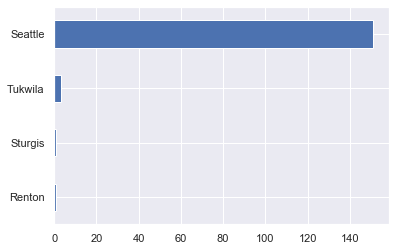

In [13]:
data.City.value_counts().sort_values().plot(kind='barh')

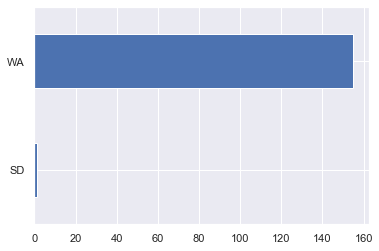

In [14]:
data.State.value_counts().sort_values().plot(kind='barh')

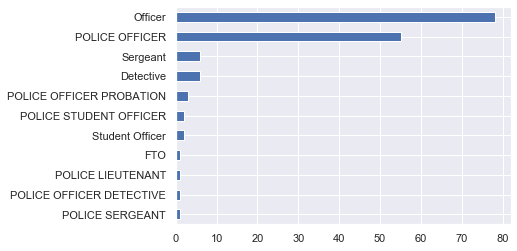

In [15]:
data.Rank.value_counts().sort_values().plot(kind='barh')

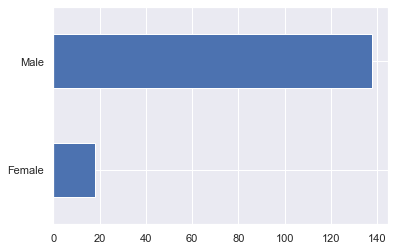

In [20]:
data['Officer Gender'].value_counts().sort_values().plot(kind='barh')

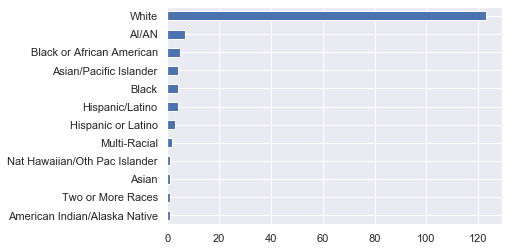

In [21]:
data['Officer Race'].value_counts().sort_values().plot(kind='barh')

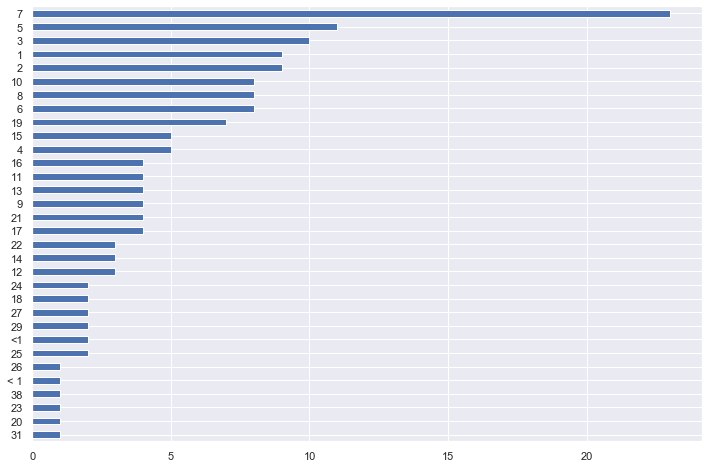

In [23]:
data['Years of SPD Service'].value_counts().sort_values().plot(kind='barh', figsize=(12,8))

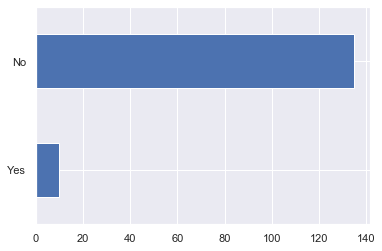

In [29]:
data['Officer Injured'].value_counts().sort_values().plot(kind='barh')

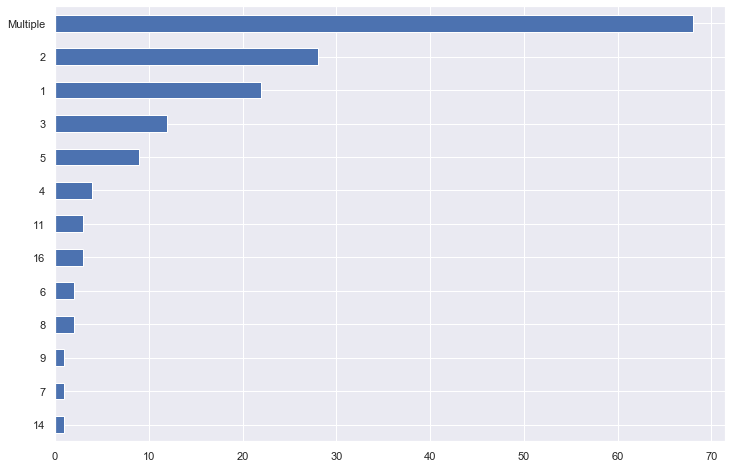

In [27]:
data['Number of Rounds'].value_counts().sort_values().plot(kind='barh', figsize=(12,8))

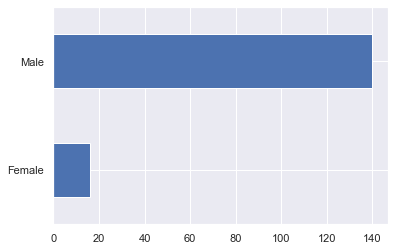

In [28]:
data['Subject Gender'].value_counts().sort_values().plot(kind='barh')

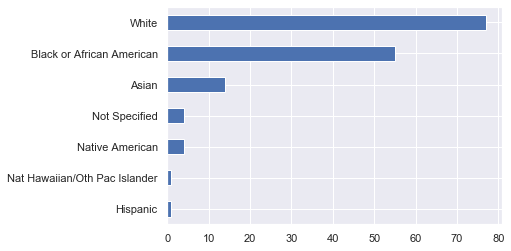

In [31]:
data['Subject Race'].value_counts().sort_values().plot(kind='barh')

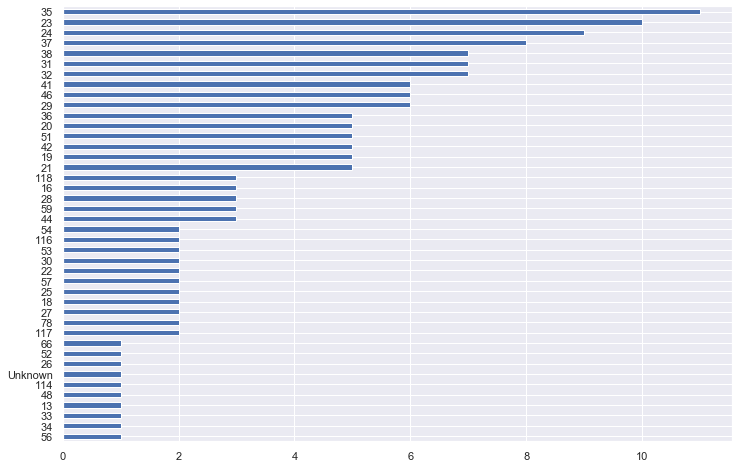

In [32]:
data['Subject Age'].value_counts().sort_values().plot(kind='barh', figsize=(12,8))
# Not sure how there's people over the age of 100 on here

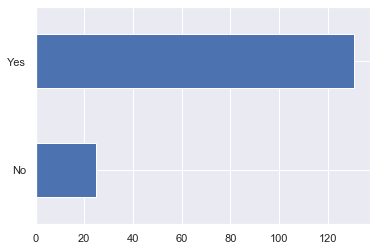

In [33]:
data['Subject Weapon'].value_counts().sort_values().plot(kind='barh')

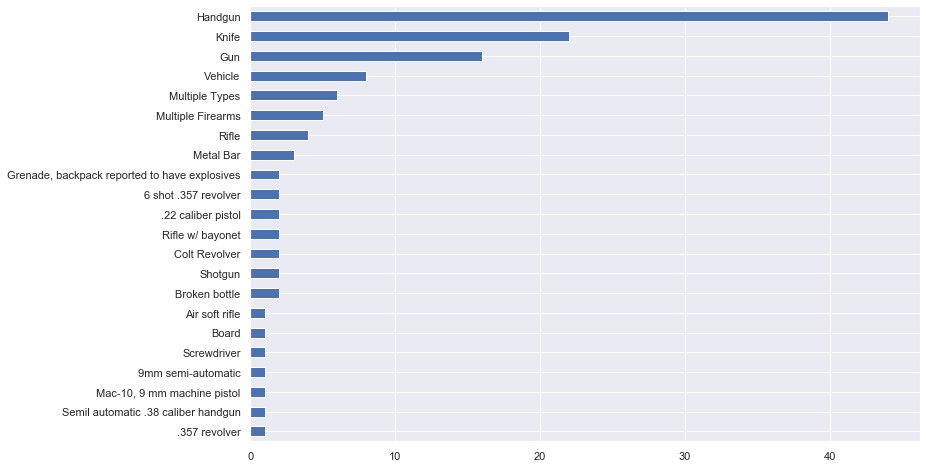

In [35]:
data['Type of Weapon'].value_counts().sort_values().plot(kind='barh', figsize=(12,8))

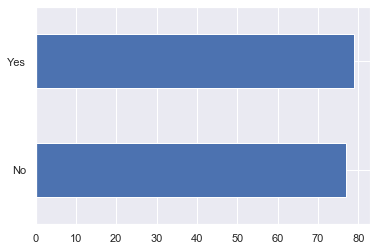

In [36]:
data['Fatal'].value_counts().sort_values().plot(kind='barh')

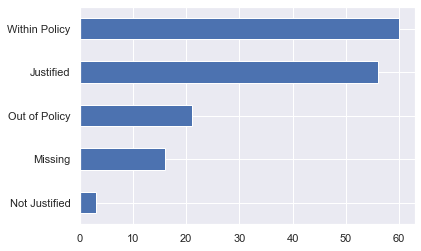

In [37]:
data['Disposition'].value_counts().sort_values().plot(kind='barh')

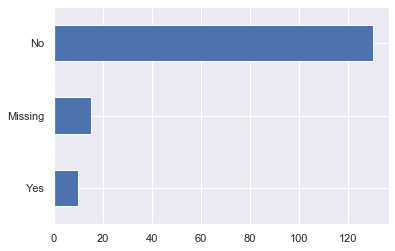

In [38]:
data['Officer Disciplined?'].value_counts().sort_values().plot(kind='barh')

In [43]:
for row in data[:15].itertuples():
    print(row.Summary.strip().rstrip() + "\n----------------")

On March 21st, 2005, at approximately 5:20 P.M., Seattle Police Officers responded to the 6500 block of Rainier Avenue South to investigate a reported domestic disturbance. When officers arrived, they found the subject holding a 10 month old child hostage. Hostage Negotiation Team (HNT) and Special Weapons and Tactics (SWAT) were called to the scene. After approximately one hour, a SWAT/K9 Officer fired one round, striking the subject. The child was rescued, unharmed.
----------------
On April 29th, 2005, at approximately 3:35 A.M., an on duty Patrol Officer responded to assist in locating a possibly suicidal person, in the area of the 1st Avenue South Bridge. The subject was located in steep terrain and bushes after having jumped from the bridge. Officers approached the subject, and while attempting to take the subject into custody, the subject made attempts to grab both officers’ firearms. An officer fired two rounds, striking the subject. 

The subject was transported by medics to H

### Things To Analyze
1. Whether certain races of officers target certain races of subjects
2. What type of crime the subject is charged with
3. When in the day do crimes happen the most?
4. If we can create bounding boxes around certain locations, what kind of crimes are likely to happen in that area?

### Modeling Ideas
1. Should an officer be disciplined for the way they handled a certain incident?

In [54]:
data[data['Incident Number'] == 20140000431136]

,Incident Number,Date / Time,Blurred Address,Longitude,Latitude,City,State,Rank,Officer Gender,Officer Race,Years of SPD Service,Officer Injured,Number of Rounds,Subject Gender,Subject Race,Subject DOB,Subject Age,Subject Weapon,Type of Weapon,Fatal,On-duty,Disposition,Officer Disciplined?,Summary
85,20140000431136,12/31/2014 09:55:00 PM,42XX BLOCK OF S EDDY ST,-122.279488,47.54511,Seattle,WA,Officer,Male,White,<1,No,3,Male,Black or African American,1984-01-02T00:00:00.000,31,No,NaN,No,Yes,Out of Policy,No,"On December 31st, 2014, at approximately 10:40..."
86,20140000431136,12/31/2014 09:55:00 PM,42XX BLOCK OF S EDDY ST,-122.279488,47.54511,Seattle,WA,Officer,Male,AI/AN,8,No,5,Male,Black or African American,1984-01-02T00:00:00.000,31,No,NaN,No,Yes,Out of Policy,No,"On December 31st, 2014, at approximately 10:40..."
87,20140000431136,12/31/2014 09:55:00 PM,42XX BLOCK OF S EDDY ST,-122.279488,47.54511,Seattle,WA,Officer,Female,White,7,No,2,Male,Black or African American,1984-01-02T00:00:00.000,31,No,NaN,No,Yes,Out of Policy,No,"On December 31st, 2014, at approximately 10:40..."
88,20140000431136,12/31/2014 09:55:00 PM,42XX BLOCK OF S EDDY ST,-122.279488,47.54511,Seattle,WA,POLICE OFFICER,Male,AI/AN,7,No,5,Female,Black or African American,1998-10-16T00:00:00.000,16,No,NaN,No,Yes,Out of Policy,No,"On December 31st, 2014, at approximately 10:40..."
89,20140000431136,12/31/2014 09:55:00 PM,42XX BLOCK OF S EDDY ST,-122.279488,47.54511,Seattle,WA,POLICE OFFICER,Female,White,7,No,2,Female,Black or African American,1998-10-16T00:00:00.000,16,No,NaN,No,Yes,Out of Policy,No,"On December 31st, 2014, at approximately 10:40..."
90,20140000431136,12/31/2014 09:55:00 PM,42XX BLOCK OF S EDDY ST,-122.279488,47.54511,Seattle,WA,POLICE OFFICER,Male,White,5,No,2,Female,Black or African American,1991-12-21T00:00:00.000,23,No,NaN,No,Yes,Out of Policy,No,"On December 31st, 2014, at approximately 10:40..."
91,20140000431136,12/31/2014 09:55:00 PM,42XX BLOCK OF S EDDY ST,-122.279488,47.54511,Seattle,WA,POLICE OFFICER,Female,White,7,No,2,Male,Black or African American,NaN,NaN,No,NaN,No,Yes,Out of Policy,No,"On December 31st, 2014, at approximately 10:40..."
92,20140000431136,12/31/2014 09:55:00 PM,42XX BLOCK OF S EDDY ST,-122.279488,47.54511,Seattle,WA,POLICE OFFICER,Female,White,7,No,2,Female,Black or African American,1991-12-21T00:00:00.000,23,No,NaN,No,Yes,Out of Policy,No,"On December 31st, 2014, at approximately 10:40..."
93,20140000431136,12/31/2014 09:55:00 PM,42XX BLOCK OF S EDDY ST,-122.279488,47.54511,Seattle,WA,POLICE OFFICER,Male,AI/AN,7,No,5,Male,Black or African American,NaN,NaN,No,NaN,No,Yes,Out of Policy,No,"On December 31st, 2014, at approximately 10:40..."
94,20140000431136,12/31/2014 09:55:00 PM,42XX BLOCK OF S EDDY ST,-122.279488,47.54511,Seattle,WA,POLICE OFFICER,Male,AI/AN,7,No,5,Female,Black or African American,1991-12-21T00:00:00.000,23,No,NaN,No,Yes,Out of Policy,No,"On December 31st, 2014, at approximately 10:40..."


In [104]:
key_phrases = {'documents': []}
for i in range(0, data.shape[0], 10):
    d = convert_text_to_JSON(data['Summary'], i, 10)
    phrases = extract_key_phrases(d)
    key_phrases['documents'] += phrases['documents']

In [ ]:
ner = {'documents': []}
for i in range(0, data.shape[0], 5):
    d = convert_text_to_JSON(data['Summary'], i, 5)
    phrases = identify_entities(d)
    ner['documents'] += phrases['documents']